In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = 'data/Data_Log_2024_01_07_10_49_00.csv'
to_calib_magn = 'data/magn_to_calib.csv'
calib_magn = 'data/calibrated_magn.csv'
out_path = 'data/calib_data_full_rot.csv'
calc_path = 'data/collected_data_full_rot.csv'

In [3]:
def normalize_array(x):
    return x / np.linalg.norm(x)

def get_rotation_matrix(q):
    q1 = q[0][0]
    q2 = q[1][0]
    q3 = q[2][0]
    q4 = q[3][0]

    c11 = q1 ** 2 + q2 ** 2 - q3 ** 2 - q4 ** 2
    c12 = 2 * (q2 * q3 - q1 * q4)
    c13 = 2 * (q2 * q4 + q1 * q3)

    c21 = 2 * (q2 * q3 + q1 * q4)
    c22 = q1 ** 2 - q2 ** 2 + q3 ** 2 - q4 ** 2
    c23 = 2 * (q3 * q4 - q1 * q2)

    c31 = 2 * (q2 * q4 - q1 * q3)
    c32 = 2 * (q3 * q4 + q1 * q2)
    c33 = q1 ** 2 - q2 ** 2 - q3 ** 2 + q4 ** 2

    return np.array([
        [c11, c12, c13],
        [c21, c22, c23],
        [c31, c32, c33]
    ])


def get_euler_angles(q):
    rotation_matrix = get_rotation_matrix(q)
    c31 = rotation_matrix[2, 0]
    beta = -c31

    threshold = 1 - 0.0000000001 #np.finfo(np.float32).eps
    sign = -1 if beta < -threshold else 1

    if beta < -threshold or beta > threshold:
        c12 = rotation_matrix[0, 1]
        c13 = rotation_matrix[0, 2]

        yaw = 0
        pitch = sign * np.pi / 2

        
        roll = np.arctan2(sign * c12, sign * c13)
    else:
 
        c21 = rotation_matrix[1, 0]
        c11 = rotation_matrix[0, 0]
        c31 = rotation_matrix[2, 0]
        c32 = rotation_matrix[2, 1]
        c33 =rotation_matrix[2, 2]

        yaw = np.arctan2(c21, c11)
        pitch = np.arcsin(-c31)
        roll = np.arctan2(c32, c33)

    yaw = yaw / np.pi * 180
    pitch = pitch / np.pi * 180
    roll = roll / np.pi * 180

    return roll, pitch, yaw

In [4]:
# CONSTANTS

G = 9.81

# A = np.array([
#     [ 0.7739, 0.0007, 0.0042],
#     [ 0.    , 1.0712, 0.0029],
#     [ 0.    , 0.    , 0.8289]
# ])

# B = np.array([-18.5799, 40.8711, 1.8040])

In [5]:
class Kalman:
    def __init__(self, dt, g_n, m_n, G_0, acc_noise, gyro_noise, mag_noise):
        self.q = np.array([[1, 0, 0, 0]]).T # kwaternion
        self.P = 0.0001 * np.eye(4) # macierz P

        self.dt = dt
        self.g_n = g_n
        self.m_n = m_n
        self.G_0 = G_0

        # szumy
        self.acc_noise = acc_noise
        self.gyro_noise = gyro_noise
        self.mag_noise = mag_noise
        
    def propagate(self, gyro_k):
        F_t = self.calculate_F(gyro_k)
        G_t = self.calculate_G()
        Q = (self.gyro_noise * self.dt)**2 * G_t @ G_t.T
        
        self.q = F_t @ self.q
        self.q = normalize_array(self.q)
        self.P = F_t @ self.P @ F_t.T + Q

    def update(self, acc_k, mag_k):
        Epsilon = self.calculate_epsilon(acc_k, mag_k)

        R = self.calculate_erros(acc_k)

        H_t = self.calculate_H()

        S = H_t @ self.P @ H_t.T + R
        K = self.P @ H_t.T @ np.linalg.inv(S)

        self.q = self.q + K @ Epsilon
        self.q = normalize_array(self.q)

        self.P = self.P - K @ H_t @ self.P
        self.P = 0.5 * (self.P + self.P.T)

    def calculate_F(self, gyro_k):
        (g1, g2, g3) = gyro_k.T[0]
        Omega = np.array([
            [0, -g1, -g2, -g3],
            [g1, 0, g3, -g2],
            [g2, -g3, 0, g1],
            [g3, g2, -g1, 0]
        ])

        return np.eye(4) + 0.5 * self.dt * Omega

    def calculate_G(self) -> np.ndarray:
        (q1, q2, q3, q4) = self.q.T[0]
        return 0.5 * np.array([
            [-q2, -q3, -q4],
            [q1, -q4, q3],
            [q4, q1, -q2],
            [-q3, q2, q1]
        ])

    def calculate_erros(self, acc_t: np.ndarray) -> np.ndarray:
        Ra = 3 * [(self.acc_noise / np.linalg.norm(acc_t))**2 + (1 - self.G_0 / np.linalg.norm(acc_t))**2]
        Rm =  3 * [self.mag_noise **2]

        return np.diag(Ra + Rm)

    def calculate_epsilon(self, acc_t: np.ndarray, mag_t: np.ndarray) -> np.ndarray:
        predicted_acc = normalize_array(-get_rotation_matrix(self.q) @ self.g_n)
        predicted_mag = normalize_array(get_rotation_matrix(self.q) @ self.m_n)

        return np.vstack((normalize_array(acc_t), mag_t)) - np.vstack((predicted_acc, predicted_mag))

    def calculate_H(self) -> np.ndarray:
        return np.vstack((
            -self.get_jacobian_matrix(self.g_n),
            self.get_jacobian_matrix(self.m_n)
        ))

    def get_jacobian_matrix(self, attribute: np.ndarray) -> np.ndarray:
        (x, y, z) = attribute.T[0]
        (q1, q2, q3, q4) = self.q.T[0]

        e00 = q1*x - q4*y + q3*z
        e01 = q2*x + q3*y + q4*z
        e02 = -q3*x + q2*y + q1*z
        e03 = -q4*x - q1*y + q2*z
        e10 = q4*x + q1*y - q2*z
        e11 = q3*x - q2*y - q1*z
        e12 = q2*x + q3*y + q4*z
        e13 = q1*x - q4*y + q3*z
        e20 = -q3*x + q2*y +q1*z
        e21 = q4*x + q1*y - q2*z
        e22 = -q1*x + q4*y - q3*z
        e23 = q2*x + q3*y + q4*z

        return 2 * np.array([
            [e00, e01, e02, e03],
            [e10, e11, e12, e13],
            [e20, e21, e22, e23]
        ])

In [6]:
raw_data = pd.read_csv(data_path, skiprows=[0])

# średnia czasu między próbkami
dt = np.mean(np.diff(raw_data['time[us]'])) / 1000000
# ilość próbek w 1 sekundzie
init_time = int(1 / dt)

# SKALOWANIE DANYCH
data = pd.DataFrame()
# mg na g
data['accX'] = raw_data['accX[mg]'] / 1000
data['accY'] = raw_data['accY[mg]'] / 1000
data['accZ'] = raw_data['accZ[mg]'] / 1000

# mdps na dps
data['gyroX'] = raw_data['gyroX[mdps]'] / 1000
data['gyroY'] = raw_data['gyroY[mdps]'] / 1000
data['gyroZ'] = raw_data['gyroZ[mdps]'] / 1000

# mG na uT
data['magX'] = raw_data['magnX[mG]'] / 10
data['magY'] = raw_data['magnY[mG]'] / 10
data['magZ'] = raw_data['magnZ[mG]'] / 10 

# zapisanie do kalibracji magnetometru
data.to_csv(to_calib_magn)


In [7]:
# wczytanie skalibronawego magnetometru
mag = pd.read_csv(calib_magn)
mag

,magX,magY,magZ
0,-12.961429,-1.814599,-43.794888
1,-12.961429,-1.814599,-43.794888
2,-11.930882,-2.096271,-43.191720
3,-11.930882,-2.096271,-43.191720
4,-14.514069,-2.936382,-43.191720
...,...,...,...
569,-14.251526,-5.175694,-43.553621
570,-14.896914,-4.428276,-43.794888
571,-14.896914,-4.428276,-43.794888
572,-14.894922,-4.427295,-44.156789


In [8]:
# BIAS
headers = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']
prepared_data = data.loc[:, headers]
data_init = prepared_data.loc[:init_time, headers]
prepared_data = prepared_data - data_init.mean()
prepared_data.loc[:, headers[2]] += 1.0
prepared_data = pd.concat([prepared_data, mag], axis=1)
prepared_data
# data_init

,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,0.093304,-0.037565,0.994261,-5.659913,-10.250478,-5.388391,-12.961429,-1.814599,-43.794888
1,0.137304,-0.027565,0.998261,-5.585913,-11.404478,-3.547391,-12.961429,-1.814599,-43.794888
2,0.137304,-0.027565,0.998261,-5.585913,-11.404478,-3.547391,-11.930882,-2.096271,-43.191720
3,0.053304,-0.033565,1.096261,-4.058913,-1.688478,6.431609,-11.930882,-2.096271,-43.191720
4,0.053304,-0.033565,1.096261,-4.058913,-1.688478,6.431609,-14.514069,-2.936382,-43.191720
...,...,...,...,...,...,...,...,...,...
569,0.103304,0.045435,0.992261,-8.581913,-11.325478,-4.151391,-14.251526,-5.175694,-43.553621
570,0.103304,0.045435,0.992261,-8.581913,-11.325478,-4.151391,-14.896914,-4.428276,-43.794888
571,0.110304,0.037435,0.991261,-7.076913,-12.113478,-3.254391,-14.896914,-4.428276,-43.794888
572,0.110304,0.037435,0.991261,-7.076913,-12.113478,-3.254391,-14.894922,-4.427295,-44.156789


In [9]:
# MAG
# data_mag = prepared_data.loc[:, ['magX', 'magY', 'magZ']].to_numpy()
# mag = data_mag.T

# mag_cal = []
# for i in range(len(mag[1])):
#     mag_cal.append(np.matmul(np.linalg.inv(A), (mag[:,i]).T) - B)
mag = np.array(mag)

# ACC
acc = prepared_data.loc[:, ['accX', 'accY', 'accZ']].to_numpy() * G

# GYRO
gyro = (prepared_data.loc[:, ['gyroX', 'gyroY', 'gyroZ']].to_numpy()) / 180 * np.pi

# MAG FIELD
m_n = mag[:init_time].mean(axis = 0)
mag_n = m_n / np.linalg.norm(m_n)
mag_n = mag_n[:, np.newaxis] 

# VAR
mag_var = mag[:init_time].var(axis=0)
acc_var = acc[:init_time].var(axis=0)
gyro_var = gyro[:init_time].var(axis=0)

# NOISE
mag_noise = 10 * np.linalg.norm(mag_var)
acc_noise = 10 * np.linalg.norm(acc_var)
gyro_noise = 10 * np.linalg.norm(gyro_var)

gravity = acc[:init_time].mean(axis=0)
gravity =  - gravity[:, np.newaxis]
gravity_0 = np.linalg.norm(gravity)

number_of_samples = prepared_data.shape[0]

prepared_data.to_csv(out_path)

array([[-12.9614288 ,  -1.81459935, -43.79488825],
       [-12.9614288 ,  -1.81459935, -43.79488825],
       [-11.93088187,  -2.09627128, -43.19172033],
       ...,
       [-14.89691427,  -4.4282757 , -43.79488825],
       [-14.89492243,  -4.4272946 , -44.15678899],
       [-14.89492243,  -4.4272946 , -44.15678899]])

In [10]:
kf = Kalman(dt, gravity, mag_n, gravity_0, acc_noise, gyro_noise, mag_noise)

In [11]:
accX_data = []
accY_data = []
accZ_data = []
gyroX_data = []
gyroY_data = []
gyroZ_data = []
magX_data = []
magY_data = []
magZ_data = []
roll_data = []
pitch_data = []
yaw_data = []

current_frame = 0

print("ORIGINAL GYRO:", gyro[0])

while current_frame < number_of_samples:
    # if (current_frame < 4900):
    #     (acc_temp, gyro_temp, mag_temp) = acc[current_frame, np.newaxis].T, gyro[current_frame, np.newaxis].T, normalize_array(mag[current_frame, np.newaxis].T)

    accX_data.append(acc[0][0])
    accY_data.append(acc[1][0])
    accZ_data.append(acc[2][0])
    gyroX_data.append(gyro[0][0])
    gyroY_data.append(gyro[1][0])
    gyroZ_data.append(gyro[2][0])
    magX_data.append(mag[0][0])
    magY_data.append(mag[1][0])
    magZ_data.append(mag[2][0])

    (acc_temp, gyro_temp, mag_temp) = acc[current_frame, np.newaxis].T, gyro[current_frame, np.newaxis].T, normalize_array(mag[current_frame, np.newaxis].T)

    kf.propagate(gyro_temp)
    kf.update(acc_temp, mag_temp)

    # if (current_frame < 4900):
    (roll, pitch, yaw) = get_euler_angles(kf.q)
    roll_data.append(roll)
    pitch_data.append(pitch)
    yaw_data.append(yaw)

    current_frame += 1

df = pd.DataFrame()
df['accX'] = accX_data
df['accY'] = accY_data
df['accZ'] = accZ_data
df['gyroX'] = gyroX_data
df['gyroY'] = gyroY_data
df['gyroZ'] = gyroZ_data
df['magX'] = magX_data
df['magY'] = magY_data
df['magZ'] = magZ_data
df['roll'] = roll_data
df['pitch'] = pitch_data
df['yaw'] = yaw_data
df.to_csv(calc_path)
df

ORIGINAL GYRO: [-0.09878412 -0.1789046  -0.09404517]


,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,roll,pitch,yaw
0,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,-0.213169,-0.361994,-0.234946
1,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,-0.424788,-0.711343,-0.387997
2,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,-0.629571,-1.043246,-0.540016
3,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,-0.760309,-1.030764,-0.258724
4,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,-0.887249,-1.017349,0.022423
...,...,...,...,...,...,...,...,...,...,...,...,...
569,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,8.867703,-28.719987,-151.414011
570,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,8.487761,-28.691831,-151.791089
571,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,8.151943,-28.709319,-152.133484
572,0.915316,1.346956,1.346956,-0.098784,-0.097493,-0.097493,-12.961429,-12.961429,-11.930882,7.824549,-28.728690,-152.477510


In [ ]:
data

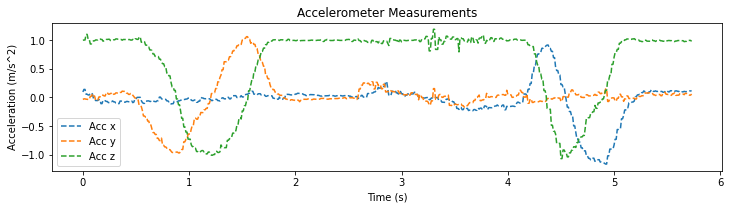

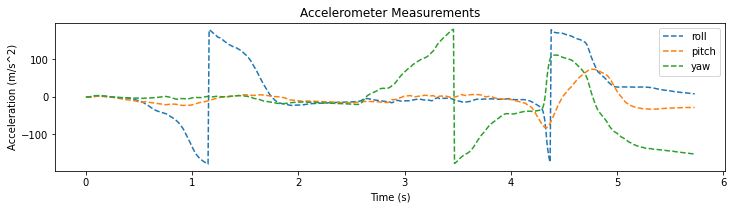

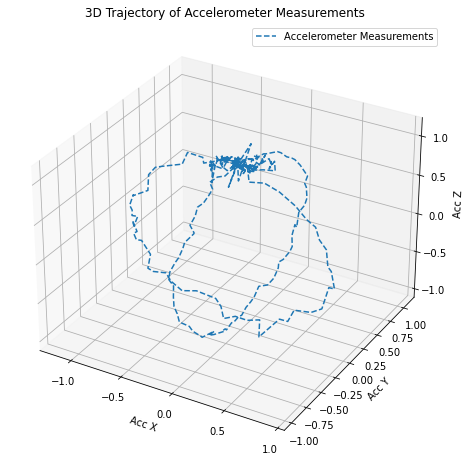

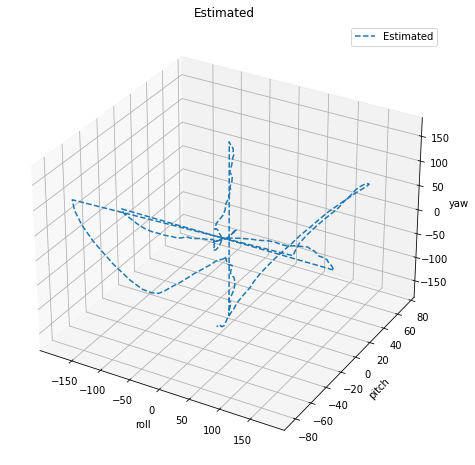

In [12]:
sensor_data  = pd.read_csv(out_path)

# # Extract true quaternion components
acc_measurements = sensor_data[['accX', 'accY', 'accZ']].values
# gyro_measurements = sensor_data[['gyroX', 'gyroY', 'gyroZ']].values
# mag_measurements = sensor_data[['magX', 'magY', 'magZ']].values

num_steps = len(acc_measurements)
dt = 0.01


for i in range(num_steps):
    # gyro_measurement = gyro_measurements[i, :]
    acc_measurement = acc_measurements[i, :]
    # mag_measurement = mag_measurements[i, :]


# # Plot the results
time_steps = np.arange(0, num_steps * dt, dt)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_steps, acc_measurements[:, 0], label='Acc x', linestyle='--')
plt.plot(time_steps, acc_measurements[:, 1], label='Acc y', linestyle='--')
plt.plot(time_steps, acc_measurements[:, 2], label='Acc z', linestyle='--')
plt.title('Accelerometer Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()


plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_steps, df['roll'], label='roll', linestyle='--')
plt.plot(time_steps, df['pitch'], label='pitch', linestyle='--')
plt.plot(time_steps, df['yaw'], label='yaw', linestyle='--')
plt.title('Accelerometer Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

# Plot the 3D trajectory of accelerometer measurements
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(acc_measurements[:, 0], acc_measurements[:, 1], acc_measurements[:, 2], label='Accelerometer Measurements', linestyle='--')
ax.set_xlabel('Acc X')
ax.set_ylabel('Acc Y')
ax.set_zlabel('Acc Z')
ax.set_title('3D Trajectory of Accelerometer Measurements')
ax.legend()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(df['roll'], df['pitch'], df['yaw'], label='Estimated', linestyle='--')
ax.set_xlabel('roll')
ax.set_ylabel('pitch')
ax.set_zlabel('yaw')
ax.set_title('Estimated')
ax.legend()

plt.show()

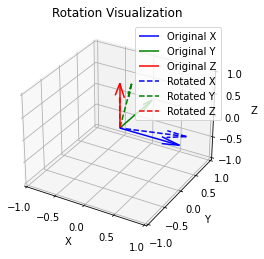

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Replace these angles with your actual roll, pitch, and yaw values
roll_angle = df['roll'][170]  # in degrees
pitch_angle = df['pitch'][170]  # in degrees
yaw_angle = df['roll'][170]  # in degrees

# Convert angles to radians
roll_angle_rad = np.radians(roll_angle)
pitch_angle_rad = np.radians(pitch_angle)
yaw_angle_rad = np.radians(yaw_angle)

# Define rotation matrix
rotation_matrix = np.array([
    [np.cos(yaw_angle_rad) * np.cos(pitch_angle_rad),
     -np.sin(yaw_angle_rad) * np.cos(roll_angle_rad) + np.cos(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.sin(roll_angle_rad),
     np.sin(yaw_angle_rad) * np.sin(roll_angle_rad) + np.cos(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.cos(roll_angle_rad)],
    [np.sin(yaw_angle_rad) * np.cos(pitch_angle_rad),
     np.cos(yaw_angle_rad) * np.cos(roll_angle_rad) + np.sin(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.sin(roll_angle_rad),
     -np.cos(yaw_angle_rad) * np.sin(roll_angle_rad) + np.sin(yaw_angle_rad) * np.sin(pitch_angle_rad) * np.cos(roll_angle_rad)],
    [-np.sin(pitch_angle_rad),
     np.cos(pitch_angle_rad) * np.sin(roll_angle_rad),
     np.cos(pitch_angle_rad) * np.cos(roll_angle_rad)]
])

# Generate a set of points in 3D space
points = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# Apply rotation to the points
rotated_points = np.dot(rotation_matrix, points.T).T

# Plot the original and rotated points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, points[0, 0], points[0, 1], points[0, 2], color='b', label='Original X')
ax.quiver(0, 0, 0, points[1, 0], points[1, 1], points[1, 2], color='g', label='Original Y')
ax.quiver(0, 0, 0, points[2, 0], points[2, 1], points[2, 2], color='r', label='Original Z')
ax.quiver(0, 0, 0, rotated_points[0, 0], rotated_points[0, 1], rotated_points[0, 2], color='b', linestyle='dashed', label='Rotated X')
ax.quiver(0, 0, 0, rotated_points[1, 0], rotated_points[1, 1], rotated_points[1, 2], color='g', linestyle='dashed', label='Rotated Y')
ax.quiver(0, 0, 0, rotated_points[2, 0], rotated_points[2, 1], rotated_points[2, 2], color='r', linestyle='dashed', label='Rotated Z')

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rotation Visualization')
ax.legend()

plt.show()
